# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [1]:
from __future__ import annotations

from random import choices, randint, random, shuffle
from dataclasses import dataclass
from typing import Callable
from tqdm import trange
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from itertools import combinations

import lab9_lib
from lab9_lib import AbstractProblem

In [2]:
@dataclass(frozen=True, init=False)
class Individual:
    """
    Class representing an Individual.
    """

    _n_loci: int
    _genotype: tuple[int]
    _fitness: float
    _fitness_function: Callable[[Individual], float]

    def __init__(self, fitness_function: "AbstractProblem", n_loci: int, genotype: tuple[int] = None) -> None:
        """
        Constructs an individual with a certain number of loci.
        If the genotype is None, it is created randomly.

        Args:
            fitness_function: the fitness function used to compute the fitness of the individual;
            n_loci: the number of loci of the individual;
            genotype: the genotype of the individual (default is None).

        Returns:
            None.
        """
        object.__setattr__(self, "_n_loci", n_loci)
        if genotype is None:
            genotype = tuple(choices([0, 1], k=n_loci))
        object.__setattr__(self, "_genotype", genotype)
        assert len(self._genotype) == self._n_loci, 'n_loci field and genotype length do not match'
        object.__setattr__(self, "_fitness_function", fitness_function)
        object.__setattr__(self, "_fitness", fitness_function(self.genotype))

    @property
    def n_loci(self) -> int:
        return self._n_loci

    @property
    def genotype(self) -> tuple[int]:
        return self._genotype

    @property
    def fitness(self) -> float:
        return self._fitness

    @property
    def fitness_function(self) -> Callable[[Individual], float]:
        return self._fitness_function

    def __str__(self) -> str:
        return f'Individual(Zeros={self.genotype.count(0)}, Ones={self.genotype.count(1)})'

    def __repr__(self) -> str:
        return f"{''.join(str(gene) for gene in self.genotype)}"

In [3]:
def mutate(ind: Individual) -> Individual:
    """
    Change a gene in a randomly chosen locus.

    Args:
        ind: the individual to mutate.

    Returns:
        New individual with the mutated gene.
    """
    fitness_function, n_loci, genotype = ind.fitness_function, ind.n_loci, list(ind.genotype)
    index = randint(0, n_loci - 1)
    genotype[index] = 1 - genotype[index]
    return Individual(fitness_function, n_loci, tuple(genotype))


def mutate_all(ind: Individual, *, prob: float) -> Individual:
    """
    Change each gene of an individual with a given probability.

    Args:
        ind: the individual to mutate.
        prob: gene mutation probability.

    Returns:
        New individual with the mutated genes.
    """
    fitness_function, n_loci, genotype = ind.fitness_function, ind.n_loci, list(ind.genotype)
    genotype = [1 - gene if random() < prob else gene for gene in genotype]
    return Individual(fitness_function, n_loci, tuple(genotype))


def uniform_crossover(ind1: Individual, ind2: Individual) -> Individual:
    """
    Perform the crossover between two individuals by randomly selecting
    a gene from a parent for each locus.

    Args:
        ind1: first parent;
        ind2: second parent.

    Returns:
        The newborn individual is returned.
    """
    fitness_function, n_loci = ind1.fitness_function, ind1.n_loci
    randoms = [random() for _ in range(n_loci)]
    genotype = [i if r < 0.5 else o for i, o, r in zip(ind1.genotype, ind2.genotype, randoms)]
    assert len(genotype) == n_loci
    return Individual(fitness_function, n_loci, tuple(genotype))


def one_cut_crossover(ind1: Individual, ind2: Individual) -> Individual:
    """
    Perform the crossover between two individuals by swapping two random
    genome parts from the parents.

    Args:
        ind1: first parent;
        ind2: second parent.

    Returns:
        The newborn individual is returned.
    """
    fitness_function, n_loci = ind1.fitness_function, ind1.n_loci
    index = randint(0, n_loci - 1)
    offspring = Individual(fitness_function, n_loci, tuple(ind1.genotype[:index]) + tuple(ind2.genotype[index:]))
    assert len(offspring.genotype) == n_loci
    return offspring


def select_parent(population: list[Individual], tournament_size: int) -> Individual:
    """
    Select a parent by performing a tournament selection.

    Args:
        population: population from which we draw individuals to form the tournament;
        tournament_size: the tournament size.

    Returns:
        The tournament winner is returned.
    """
    pool = choices(population, k=tournament_size)
    champ = max(pool, key=lambda ind: ind.fitness)
    return champ


def create_population(fitness_function: "AbstractProblem", n_loci: int, population_size: int) -> list[Individual]:
    """
    Create a random population of a given size.

    Args:
        fitness_function: the fitness function used to compute the fitness of the individual;
        n_loci: the number of loci of the individual;
        population_size: the size of the population.

    Returns:
        A newly created population is returned.
    """
    return [Individual(fitness_function, n_loci) for _ in range(population_size)]


def update_population(
    population: list[Individual], offspring: list[Individual], population_size: int
) -> list[Individual]:
    """
    Given a population and its offspring, this function returns the population
    of the next generation by selecting the fittest individuals.

    Args:
        population: the current population;
        offspring: the offspring of the current population;
        population_size: the size of the population.

    Returns:
        The population of the next generation is returned.
    """
    population.extend(offspring)
    population.sort(key=lambda ind: ind.fitness, reverse=True)
    population = population[:population_size]
    return population


def find_best_individual(population: list[Individual]) -> Individual:
    """
    Find the fittest individual in a population.

    Args:
        population: the current population.

    Returns:
        The fittest individual is returned.
    """
    return max(population, key=lambda ind: ind.fitness)


def choose_migrants(population: list[Individual], n: int, random: bool) -> tuple[list[Individual], list[Individual]]:
    """
    Choose random or fittest migrants of a given population.

    Args:
        population: the current population;
        n: the number of migrants;
        random: choose whether the migrants are randomly drawn or they are the fittest individuals.

    Returns:
        The migrants and the remaining population are returned.
    """
    if random:
        shuffle(population)
    else:
        population.sort(key=lambda ind: ind.fitness, reverse=True)
    migrants = population[:n]
    population = population[n:]
    return migrants, population


def extinction_by_fitness(
    population: list[Individual],
    std: float,
    population_size: int,
    survivors_percentage: float,
    fitness_function: "AbstractProblem",
    n_loci: int,
) -> tuple[list[Individual], list[Individual] | None]:
    """
    Perform an extinction if the standard deviation of the population's fitnesses is below
    a certain threshold. Otherwise, return the population itself.
    If an extinction is performed, the survivors and the newly created population are returned.
    The extinction is performed by randomly selecting the survivors.

    Args:
        population: the current population;
        std: the standard deviation threshold below which extinction is performed;
        population_size: the size of the population;
        survivors_percentage: the percentage of survivors after the extinction;
        fitness_function: the fitness function used to compute the fitness of the individual;
        n_loci: the number of loci of the individual.

    Returns:
        The survivors and the newly created population are returned or
        the population itself is returned.
    """
    if np.std([ind.fitness for ind in population]) < std:
        population = choices(population, k=math.ceil(population_size * survivors_percentage))
        offspring = create_population(
            fitness_function, n_loci, math.floor(population_size * (1 - survivors_percentage))
        )
        return population, offspring
    return population, None


def edit_distance(ind1: Individual, ind2: Individual) -> Individual:
    """
    Compute the edit distance between two individuals.

    Args:
        ind1: first individual;
        ind2: second individual.

    Returns:
        The edit distance is returned.
    """
    dist = sum([e1 ^ e2 for e1, e2 in zip(ind1.genotype, ind2.genotype)])
    return dist


def extinction_by_similarity(
    population: list[Individual],
    std: float,
    population_size: int,
    survivors_percentage: float,
    fitness_function: "AbstractProblem",
    n_loci: int,
) -> list[Individual]:
    """
    Perform an extinction if the standard deviation of the population's fitnesses is below
    a certain threshold. Otherwise, return the population itself.
    If an extinction is performed, the survivors and the newly created population are returned.
    The extinction is performed by selecting as survivors the most distant individuals according to
    the edit distance.

    Args:
        population: the current population;
        std: the standard deviation threshold below which extinction is performed;
        population_size: the size of the population;
        survivors_percentage: the percentage of survivors after the extinction;
        fitness_function: the fitness function used to compute the fitness of the individual;
        n_loci: the number of loci of the individual.

    Returns:
        The survivors and the newly created population are returned or
        the population itself is returned.
    """
    if np.std([ind.fitness for ind in population]) < std:
        tot_distances = [sum([edit_distance(ind, population[i]) for i in range(population_size)]) for ind in population]
        indexes = np.argsort(tot_distances)[: math.floor(population_size * (1 - survivors_percentage))]
        population = [population[i] for i in range(population_size) if i not in indexes]
        offspring = create_population(
            fitness_function, n_loci, math.floor(population_size * (1 - survivors_percentage))
        )
        return population, offspring
    return population, None


def alter_most_promising_individuals(population: list[Individual], n: int, prob: float) -> list[Individual]:
    """
    Mutate the most promising individuals using the mutate_all function.

    Args:
        population: the current population;
        n: how many promising individuals to mutate;
        prob: gene mutation probability (mutate_all parameter).

    Returns:
        The population after the alteration is returned.
    """
    population.sort(key=lambda ind: ind.fitness, reverse=True)
    for i in range(n):
        population[i] = mutate_all(population[i], prob=prob)
    return population


def plot_fitnesses_by_generations(islands: list[list[Individual]], n_islands: int) -> None:
    """
    Plot the best fitnesses of each island.

    Args:
        islands: the islands of populations;
        n_islands: the number of islands.

    Returns:
        None.
    """
    hex_values = "0123456789ABCDEF"
    colors = ["#" + ''.join(choices(hex_values, k=6)) for _ in range(n_islands)]
    for i, fitnesses in enumerate(islands):
        plt.plot(fitnesses, label='island' + str(i + 1), color=colors[i])
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Best Fitness Values")
    plt.xlabel("Generations")
    plt.ylabel("Fitness Values")
    plt.legend()
    plt.show()

# Explanation of hyperparameters
* `PROBLEM_SIZE`: select the problem istance;
* `LOCI`: fix the number of loci of a genome;
* `POPULATION_SIZE`: set the number of individuals in a population;
* `OFFSPRING_SIZE`: select how many new individuals to produce in each generation;
* `TOURNAMENT_SIZE`: set the size of the tournament selection;
* `MUTATION_PROBABILITY`: probability of doing mutation instead of crossover;
* `CROSSOVER_MUTATION`: probability of doing crossover + mutation instead of mutation only;
* `GENERATIONS`: number of generations to run each algorithm;
* `FITNESS_FUNCTION`: set the fitness function to evaluate how good an individual is;
* `SURVIVORS_PERCENTAGE`: set the percentage of survivors after an extinction;
* `STD`: set the standard deviation threshold below which an **extinction** is performed;
* `NUMBER_ALTERED_PROMISING_POINTS`: how many promising individuals to mutate for the **sequential niching method**;
* `PROB`: set gene mutation probability;
* `NUMBER_OF_ISLANDS`: select how many islands to use for the **island model**;
* `MIGRATION_TIME`: set the number of generations after which the migration is performed;
* `NUMBER_OF_MIGRANTS`: select the number of individuals to migrate.

## Problem Instance: 1
* **_crossover_**
* **_mutation_**
* **_tournament selection_**

To solve instance 1, I just implemented a simple GA algorithm using `one_cut_crossover` as the crossover operation. \
In this case, mutation and crossover are exclusive, i.e. if I perform a crossover, I do not perform a mutation, and vice versa. \
The values for the hyperparameters are given below:

In [46]:
PROBLEM_SIZE = 1
LOCI = 1000
POPULATION_SIZE = 30
OFFSPRING_SIZE = 20
TOURNAMENT_SIZE = 2
MUTATION_PROBABILITY = 0.80
GENERATIONS = 5_000

FITNESS_FUNCTION = lab9_lib.make_problem(PROBLEM_SIZE)

In [47]:
population = create_population(FITNESS_FUNCTION, LOCI, POPULATION_SIZE)
generation_best_fitnesses = [find_best_individual(population).fitness]

pbar = trange(GENERATIONS)
for generation in pbar:
    offspring = []
    for _ in range(OFFSPRING_SIZE):
        if random() < MUTATION_PROBABILITY:
            parent = select_parent(population, TOURNAMENT_SIZE)
            child = mutate(parent)
        else:
            parent1 = select_parent(population, TOURNAMENT_SIZE)
            parent2 = select_parent(population, TOURNAMENT_SIZE)
            child = one_cut_crossover(parent1, parent2)
        offspring.append(child)

    population = update_population(population, offspring, POPULATION_SIZE)
    generation_best_fitnesses.append(population[0].fitness)
    pbar.set_description(f'Best Fitness {population[0].fitness:.2%}')

    if math.isclose(1, population[0].fitness):
        break

print(f"Best individual: {population[0]}, fitness: {population[0].fitness:.2%}")

Best Fitness 100.00%:  25%|██▍       | 1235/5000 [00:01<00:06, 627.19it/s]


Best individual: Individual(Zeros=0, Ones=1000), fitness: 100.00%


In [48]:
print(f'Number of fitness calls: {FITNESS_FUNCTION.calls:,}')

Number of fitness calls: 24,750


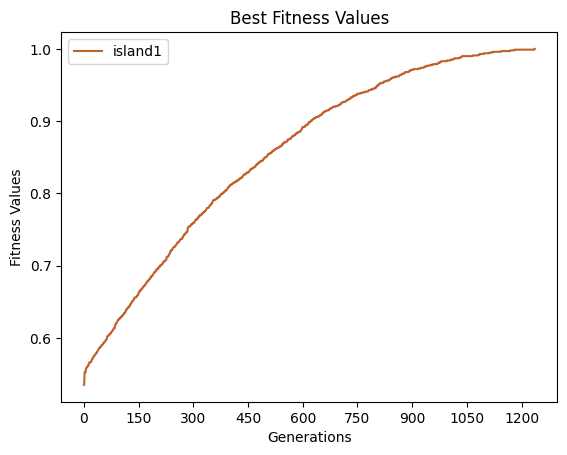

In [55]:
plot_fitnesses_by_generations([generation_best_fitnesses], 1)

## Problem Instance: 2
* **_crossover_**
* **_mutation_**
* **_tournament selection_**
* **_extinction_**

To solve problem instance 2, I chose to promote diversity through _extinction_, based on the idea that in the case of convergence of fitness in the population, it is better to replace random individuals of the current population with new ones. \
With respect to problem instance 1, the mutation is always performed here, as I noticed a big performance gain with this change, and I also used `uniform_crossover` as the crossover operation. \
The values for the hyperparameters are given below:

In [58]:
PROBLEM_SIZE = 2
LOCI = 1000
POPULATION_SIZE = 50
OFFSPRING_SIZE = 25
TOURNAMENT_SIZE = 2
CROSSOVER_MUTATION = 0.35
GENERATIONS = 20_000
SURVIVORS_PERCENTAGE = 0.15
STD = 0.0005

FITNESS_FUNCTION = lab9_lib.make_problem(PROBLEM_SIZE)

In [59]:
population = create_population(FITNESS_FUNCTION, LOCI, POPULATION_SIZE)
best_individual = find_best_individual(population)
generation_best_fitnesses = [best_individual.fitness]

pbar = trange(GENERATIONS)
for generation in pbar:
    # extinction
    population, offspring = extinction_by_fitness(
        population, STD, POPULATION_SIZE, SURVIVORS_PERCENTAGE, FITNESS_FUNCTION, LOCI
    )

    if offspring is None:
        offspring = []
        for _ in range(OFFSPRING_SIZE):
            if random() < CROSSOVER_MUTATION:
                parent1 = select_parent(population, TOURNAMENT_SIZE)
                parent2 = select_parent(population, TOURNAMENT_SIZE)
                child = mutate(uniform_crossover(parent1, parent2))
            else:
                parent = select_parent(population, TOURNAMENT_SIZE)
                child = mutate(parent)
            offspring.append(child)

    population = update_population(population, offspring, POPULATION_SIZE)
    generation_best_fitnesses.append(population[0].fitness)
    pbar.set_description(f'Best Fitness {population[0].fitness:.2%}')

    if population[0].fitness > best_individual.fitness:
        best_individual = population[0]

    if math.isclose(1, population[0].fitness):
        break

print(f"Best individual: {best_individual}, fitness: {best_individual.fitness:.2%}")

Best Fitness 100.00%:  52%|█████▏    | 10430/20000 [00:34<00:31, 303.06it/s]

Best individual: Individual(Zeros=0, Ones=1000), fitness: 100.00%


In [60]:
print(f'Number of fitness calls: {FITNESS_FUNCTION.calls:,}')

Number of fitness calls: 352,316


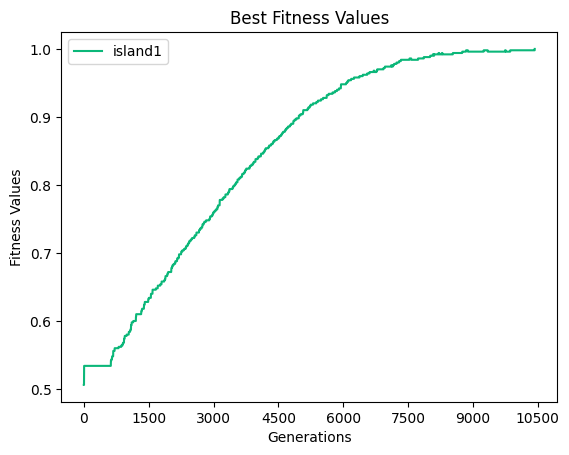

In [61]:
plot_fitnesses_by_generations([generation_best_fitnesses], 1)

## Problem Instance: 5

I did not manage to solve this problem instance 😔.

### First attempt
* **_crossover_**
* **_mutation_**
* **_tournament selection_**
* **_extinction_**

As a first attempt, I tried to use the same setting of problem instance 2, but with different hyperparameters.

In [39]:
PROBLEM_SIZE = 5
LOCI = 1000
POPULATION_SIZE = 100
OFFSPRING_SIZE = 50
TOURNAMENT_SIZE = 5
CROSSOVER_MUTATION = 0.35
GENERATIONS = 30_000
SURVIVORS_PERCENTAGE = 0.05
STD = 0.0005

FITNESS_FUNCTION = lab9_lib.make_problem(PROBLEM_SIZE)

In [40]:
population = create_population(FITNESS_FUNCTION, LOCI, POPULATION_SIZE)
best_individual = find_best_individual(population)
generation_best_fitnesses = [best_individual.fitness]

pbar = trange(GENERATIONS)
for generation in pbar:
    # extinction
    population, offspring = extinction_by_fitness(
        population, STD, POPULATION_SIZE, SURVIVORS_PERCENTAGE, FITNESS_FUNCTION, LOCI
    )

    if offspring is None:
        offspring = []
        for _ in range(OFFSPRING_SIZE):
            if random() < CROSSOVER_MUTATION:
                parent1 = select_parent(population, TOURNAMENT_SIZE)
                parent2 = select_parent(population, TOURNAMENT_SIZE)
                child = mutate(uniform_crossover(parent1, parent2))
            else:
                parent = select_parent(population, TOURNAMENT_SIZE)
                child = mutate(parent)
            offspring.append(child)

    population = update_population(population, offspring, POPULATION_SIZE)
    generation_best_fitnesses.append(population[0].fitness)
    pbar.set_description(f'Best Fitness {population[0].fitness:.2%}')

    if population[0].fitness > best_individual.fitness:
        best_individual = population[0]

    if math.isclose(1, population[0].fitness):
        break

print(f"Best individual: {best_individual}, fitness: {best_individual.fitness:.2%}")

Best Fitness 80.00%: 100%|██████████| 30000/30000 [03:09<00:00, 158.41it/s]

Best individual: Individual(Zeros=200, Ones=800), fitness: 80.00%


In [41]:
print(f'Number of fitness calls: {FITNESS_FUNCTION.calls:,}')

Number of fitness calls: 2,025,726


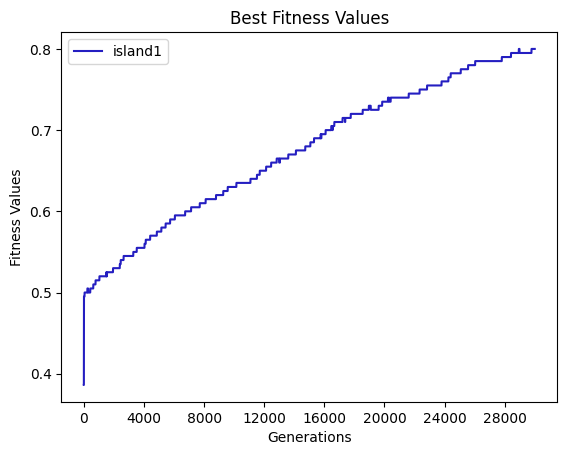

In [42]:
plot_fitnesses_by_generations([generation_best_fitnesses], 1)

### Second attempt
* **_crossover_**
* **_mutation_**
* **_tournament selection_**
* **_extinction_**
* **_sequential niching_**

I further tried to promote diversity by implementing a _sequential niching_ strategy, where the fittest individuals in each generation are randomly altered to become less interesting. \
I noticed an improvement, although I was not able to reach the maximum fitness value.

Here I also used _extiction_ in the case of fitness convergence in the population, but instead of randomly killing individuals, I chose to sacrifice the most similar individuals based on the `edit_distance` of the genotypes.

In [53]:
PROBLEM_SIZE = 5
LOCI = 1000
POPULATION_SIZE = 100
OFFSPRING_SIZE = 50
TOURNAMENT_SIZE = 5
CROSSOVER_MUTATION = 0.35
GENERATIONS = 30_000
SURVIVORS_PERCENTAGE = 0.25
STD = 0.001
NUMBER_ALTERED_PROMISING_POINTS = 5
PROB = 0.05

FITNESS_FUNCTION = lab9_lib.make_problem(PROBLEM_SIZE)

In [54]:
population = create_population(FITNESS_FUNCTION, LOCI, POPULATION_SIZE)
best_individual = find_best_individual(population)
generation_best_fitnesses = [best_individual.fitness]

pbar = trange(GENERATIONS)
for generation in pbar:
    # extinction
    population, offspring = extinction_by_similarity(
        population, STD, POPULATION_SIZE, SURVIVORS_PERCENTAGE, FITNESS_FUNCTION, LOCI
    )

    if offspring is None:
        offspring = []
        for _ in range(OFFSPRING_SIZE):
            if random() < CROSSOVER_MUTATION:
                parent1 = select_parent(population, TOURNAMENT_SIZE)
                parent2 = select_parent(population, TOURNAMENT_SIZE)
                child = mutate(uniform_crossover(parent1, parent2))
            else:
                parent = select_parent(population, TOURNAMENT_SIZE)
                child = mutate(parent)
            offspring.append(child)

    population = update_population(population, offspring, POPULATION_SIZE)
    generation_best_fitnesses.append(population[0].fitness)
    pbar.set_description(f'Best Fitness {population[0].fitness:.2%}')

    if population[0].fitness > best_individual.fitness:
        best_individual = population[0]

    if math.isclose(1, population[0].fitness):
        break

    # sequential niching
    population = alter_most_promising_individuals(population, NUMBER_ALTERED_PROMISING_POINTS, PROB)

print(f"Best individual: {best_individual}, fitness: {best_individual.fitness:.2%}")

  0%|          | 0/30000 [00:00<?, ?it/s]

Best Fitness 83.50%: 100%|██████████| 30000/30000 [03:51<00:00, 129.68it/s]

Best individual: Individual(Zeros=165, Ones=835), fitness: 83.50%


In [58]:
print(f'Number of fitness calls: {FITNESS_FUNCTION.calls:,}')

Number of fitness calls: 2,174,904


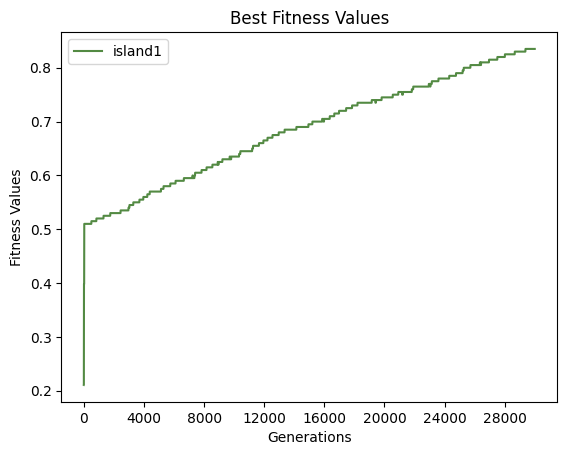

In [57]:
plot_fitnesses_by_generations([generation_best_fitnesses], 1)

## Problem Instance: 10

### First attempt
* **_crossover_**
* **_mutation_**
* **_tournament selection_**
* **_extinction_**
* **_island model_**

To try to solve this difficult problem, I decided to implement an _island model_ by performing periodic migration of individuals only between predefined pairs of islands. \
The typical number of migrants is between 2 and 5. Here I used half the population because this gave me the best result.

I also tried to increase the number of islands to 250, which should give better results, but I was unable to complete this trial due to limited computing resources.

In [46]:
PROBLEM_SIZE = 10
LOCI = 1000
POPULATION_SIZE = 50
OFFSPRING_SIZE = 25
TOURNAMENT_SIZE = 2
CROSSOVER_MUTATION = 0.25
GENERATIONS = 10_000
SURVIVORS_PERCENTAGE = 0.15
STD = 0.0005
NUMBER_OF_ISLANDS = 50
MIGRATION_TIME = 50
NUMBER_OF_MIGRANTS = 25

FITNESS_FUNCTION = lab9_lib.make_problem(PROBLEM_SIZE)

In [47]:
islands = [create_population(FITNESS_FUNCTION, LOCI, POPULATION_SIZE) for _ in range(NUMBER_OF_ISLANDS)]
tmp_best_islands_individuals = list(map(find_best_individual, islands))
best_individual = find_best_individual(tmp_best_islands_individuals)
generation_best_fitnesses = [[ind.fitness] for ind in tmp_best_islands_individuals]

pbar = trange(GENERATIONS)
for generation in pbar:
    migrate = (generation + 1) % MIGRATION_TIME == 0
    if migrate:
        new_islands = []
        for _ in range(int(NUMBER_OF_ISLANDS // 2)):
            island1, island2 = islands.pop(), islands.pop()
            migrants1, island1 = choose_migrants(island1, NUMBER_OF_MIGRANTS, random=False)
            migrants2, island2 = choose_migrants(island2, NUMBER_OF_MIGRANTS, random=False)
            island1.extend(migrants2)
            island2.extend(migrants1)
            new_islands.extend([island1, island2])
        if len(islands) == 1:
            new_islands.append(islands.pop())
        islands = new_islands
    new_islands = []
    for island in islands:
        # extinction
        island, offspring = (
            extinction_by_fitness(island, STD, POPULATION_SIZE, SURVIVORS_PERCENTAGE, FITNESS_FUNCTION, LOCI)
            if not migrate
            else (island, None)
        )

        if offspring is None:
            offspring = []
            for _ in range(OFFSPRING_SIZE):
                if random() < CROSSOVER_MUTATION:
                    parent1 = select_parent(island, TOURNAMENT_SIZE)
                    parent2 = select_parent(island, TOURNAMENT_SIZE)
                    child = mutate(one_cut_crossover(parent1, parent2))
                else:
                    parent = select_parent(island, TOURNAMENT_SIZE)
                    child = mutate(parent)
                offspring.append(child)
        island = update_population(island, offspring, POPULATION_SIZE)
        new_islands.append(island)
    islands = new_islands

    tmp_best_islands_individuals = list(map(find_best_individual, islands))
    best_current_generation = find_best_individual(tmp_best_islands_individuals)
    for i, ind in enumerate(tmp_best_islands_individuals):
        generation_best_fitnesses[i].append(ind.fitness)
    pbar.set_description(f'Best Fitness {best_current_generation.fitness:.2%}')

    if best_current_generation.fitness > best_individual.fitness:
        best_individual = best_current_generation

    if math.isclose(1, best_current_generation.fitness):
        break

print(f"Best individual: {best_individual}, fitness: {best_individual.fitness:.2%}")

Best Fitness 53.00%: 100%|██████████| 10000/10000 [19:36<00:00,  8.50it/s]

Best individual: Individual(Zeros=470, Ones=530), fitness: 53.00%


In [48]:
print(f'Number of fitness calls: {FITNESS_FUNCTION.calls:,}')

Number of fitness calls: 16,075,210


### Second attempt
* **_crossover_**
* **_mutation_**
* **_tournament selection_**
* **_extinction_**
* **_island model_**
* **_two level diversity selection_**

To further increase the diversity I implemented a _two level diversity selection_. Due to limited computing resources, I decided to reduce the number of islands from 50 to 4, just to test the performance of this new technique.

In [21]:
PROBLEM_SIZE = 10
LOCI = 1000
POPULATION_SIZE = 100
OFFSPRING_SIZE = 50
TOURNAMENT_SIZE = 5
CROSSOVER_MUTATION = 0.35
GENERATIONS = 10_000
SURVIVORS_PERCENTAGE = 0.05
STD = 0.0005
NUMBER_OF_ISLANDS = 4
MIGRATION_TIME = 50
NUMBER_OF_MIGRANTS = 5

FITNESS_FUNCTION = lab9_lib.make_problem(PROBLEM_SIZE)

In [104]:
islands = [create_population(FITNESS_FUNCTION, LOCI, POPULATION_SIZE) for _ in range(NUMBER_OF_ISLANDS)]
tmp_best_islands_individuals = list(map(find_best_individual, islands))
best_individual = find_best_individual(tmp_best_islands_individuals)
generation_best_fitnesses = [[ind.fitness] for ind in tmp_best_islands_individuals]

pbar = trange(GENERATIONS)
for generation in pbar:
    migrate = (generation + 1) % MIGRATION_TIME == 0
    if migrate:
        new_islands = []
        for _ in range(int(NUMBER_OF_ISLANDS // 2)):
            island1, island2 = islands.pop(), islands.pop()
            migrants1, island1 = choose_migrants(island1, NUMBER_OF_MIGRANTS, random=False)
            migrants2, island2 = choose_migrants(island2, NUMBER_OF_MIGRANTS, random=False)
            island1.extend(migrants2)
            island2.extend(migrants1)
            new_islands.extend([island1, island2])
        if len(islands) == 1:
            new_islands.append(islands.pop())
        islands = new_islands
    new_islands = []
    for island in islands:
        # extinction
        island, offspring = (
            extinction_by_fitness(island, STD, POPULATION_SIZE, SURVIVORS_PERCENTAGE, FITNESS_FUNCTION, LOCI)
            if not migrate
            else (island, None)
        )

        if offspring is None:
            offspring = []
            for _ in range(OFFSPRING_SIZE):
                if random() < CROSSOVER_MUTATION:
                    parent1 = select_parent(island, TOURNAMENT_SIZE)
                    parent2 = select_parent(island, TOURNAMENT_SIZE)
                    parent3 = select_parent(island, TOURNAMENT_SIZE)

                    # two level diversity selection
                    parent1, parent2, _ = max(
                        [(p1, p2, edit_distance(p1, p2)) for p1, p2 in combinations([parent1, parent2, parent3], 2)],
                        key=lambda i: i[2],
                    )

                    child = mutate(one_cut_crossover(parent1, parent2))
                else:
                    parent = select_parent(island, TOURNAMENT_SIZE)
                    child = mutate(parent)
                offspring.append(child)
        island = update_population(island, offspring, POPULATION_SIZE)
        new_islands.append(island)
    islands = new_islands

    tmp_best_islands_individuals = list(map(find_best_individual, islands))
    best_current_generation = find_best_individual(tmp_best_islands_individuals)
    for i, ind in enumerate(tmp_best_islands_individuals):
        generation_best_fitnesses[i].append(ind.fitness)
    pbar.set_description(f'Best Fitness {best_current_generation.fitness:.2%}')

    if best_current_generation.fitness > best_individual.fitness:
        best_individual = best_current_generation

    if math.isclose(1, best_current_generation.fitness):
        break

print(f"Best individual: {best_individual}, fitness: {best_individual.fitness:.2%}")

Best Fitness 40.65%: 100%|██████████| 10000/10000 [04:37<00:00, 36.03it/s]

Best individual: Individual(Zeros=577, Ones=423), fitness: 40.71%


In [107]:
print(f'Number of fitness calls: {FITNESS_FUNCTION.calls:,}')

Number of fitness calls: 2,790,650


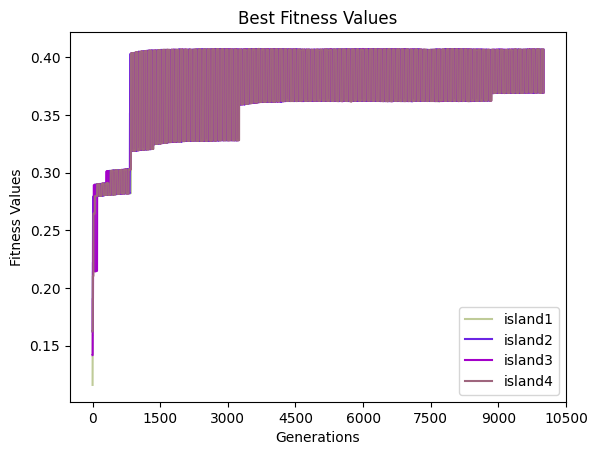

In [112]:
plot_fitnesses_by_generations(generation_best_fitnesses, NUMBER_OF_ISLANDS)